# Overview
Our project explores the topic of how YouTube music videos can possibly influences an artist's popuarity as can be shown through streaming service streams like Spotify and iTunes as well as social media. We obtained our datasets from online sources and combined them into one. Then explored the dataset by looking for relationship between variables and gained insight on how music videos can greatly affect an artist's popuarity.

# Group Members

- Hillary Thi
- Daniel Fernandez 
- Elizabeth Turrubiartes Campos
- Haoyu Huang
- Annie Bounchaleun


# Group Members IDs

- A12941046
- A13657224
- A13776394
- A13777401
- A13960911

# Introduction and Background

## Background and Prior Work
Music has always been an integral component of culture and has become increasingly so with the emergence of the digital age. With the widespread usage of media distribution platforms such as YouTube, artists have been able to share their music with a larger international audience due to easier access and distribution. Since the emergence of the platform in 2005, the YouTube community has seen a steady upward trend in users, now boasting about a 60% usage rate amongst all Americans. 

Because of the inevitable impact that YouTube has on the music industry, we decided to explore the relationship between an artist’s YouTube popularity (views, likes, subscribers) and their overall popularity (streams, album sales, concert sales, social media engagement). We will be quantifying artist success by analyzing data from  Billboard Charts, Spotify and iTunes streams and then identifying whether or not there is a significant correlation to artists’ YouTube statistics.

Billboard has collected data and monitored trends on music popularity since the mid-1900s, so we believe that there will be a sufficient amount of data for us to explore. We will likely use a subset of data from the Billboard Hot 100, Billboard 200, Artist 100, Billboard Social 50, and Year End charts to perform our classification on. To do this, we will use a Billboard API to extract the figures we need. The YouTube statistics are more straightforward and can be obtained through (https://socialblade.com/youtube/) for artist engagement and (https://kworb.net/) for top YouTube view rankings.

Through exploring the relationship between YouTube views and overall popularity, we can see how much importance a music video has on promoting the artist. We can also see how the visual impact of the music video rather than the song itself can determine the song's success.

References (include links):
- 1) https://blog.hubspot.com/marketing/youtube-stats
- 2) https://en.wikipedia.org/wiki/Billboard_Hot_100#History

## Research Question
Is there a correlation between the number of YouTube views and artist popularity?

## Hypothesis

We hypothesized that there would be a positive correlation between an artist’s YouTube popularity and overall popularity, due to widespread music distribution to increasingly diverse audiences and the incorporation of popular songs in mainstream media.

# Datasets

- Dataset Name: youtube_data.csv
- Link to the dataset: https://kworb.net/youtube/weekly/archive.html
- Number of observations: 16182  

We scaped this dataset from kworb.net. This dataset has the weekly views and view increase of a music video (top 199) from 2017 to 2018. The columns include the date, artist, title, number of weeks on the chart, position on the chart, peak position, views, and view increase. 

- Dataset Name: spotify_data.csv
- Link to the dataset: https://spotifycharts.com/regional/us/daily/
- Number of observations: 145384

We used a Python package fycharts (https://pypi.org/project/fycharts/) to obtain this dataset. This dataset has the daily stream count of a song (top 200) on Spotify from 2017 to 2018. The columns include the date, artist, title, stream count, and position on the chart.

- Dataset Name: kworb_itunes.json
- Link to the dataset: https://kworb.net/pop/archive/
- Number of observations: 73000

We scaped this dataset from kworb.net. This dataset has the daily popularity index from a song (top 100) on iTunes from 2017 to 2018. The columns include the date, artist, title, and iTunes popularity.

- Dataset Name: social-50.json
- Link to the dataset: https://www.billboard.com/charts/social-50/
- Number of observations: 21950

We used an Python API `billboard.py` (https://github.com/guoguo12/billboard-charts) to obtain the dataset. This dataset has the weekly social popularity of artists on Billboard Social 50 from 2011 to 2018. The columns include the date, artist, chart position, and peak position.

To combine these 4 datasets, we decide to explore the data only from 2017 to 2018 because the two years is their intersection. Also, for the daily dataset, we simply keep the date that the weekly dataset has. Then we need to merge the datasets on dates, artist, and song title (if there is). However, since a lot of the data entries from YouTube have inconsistent title and artist names with the Spotify and iTunes, we need to do a lot of work to clean the data.

# Setup

In [ ]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows',2000)

from collections import Counter
from collections import defaultdict
from sys import stdout as std
import patsy
import seaborn as sns
from sklearn import datasets, linear_model
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Data Cleaning

## Load data from files

In [ ]:
# Load in SOCIAL-50 json file
        # Format: 
        # [{"peakPos": 1, 
        #   "artist": "Justin Bieber", 
        #   "lastPos": 1, 
        #   "title": "", 
        #   "isNew": false, 
        #   "rank": 1, 
        #   "weeks": 21},...]

def read_json_social(fname):

    with open(fname) as json_file:  
        data = json.load(json_file)

    date = [ day for day in data for _ in range(0,len(data[day])) ]
    artist = [ rank['artist'] for day in data for rank in data[day] ]
    peak_pos = [ int(rank['peakPos']) for day in data for rank in data[day] ]
    last_pos = [ int(rank['lastPos']) for day in data for rank in data[day] ]
    weeks = [ int(rank['weeks']) for day in data for rank in data[day] ]
    ranking = [ int(rank['rank']) for day in data for rank in data[day] ]
    
    # Check that all are same length
    if not (len(date) == len(artist) == len(peak_pos) == len(last_pos) 
            == len(weeks) == len(ranking)):
        print("ERROR: Arrays are different sizes")

    return pd.DataFrame( {'artist':artist,'50_rank':ranking, '50_pk':peak_pos,
                          '50_last':last_pos, '50_wks':weeks,'date':date})


# Load in ITUNES json file
def read_json_itunes(fname):

    with open(fname) as json_file:  
        data = json.load(json_file)

    date = [ day for day in data for _ in range(0,len(data[day])) ]
    artist = [ rank['artist'] for day in data for rank in data[day] ]
    title = [ rank['title'] for day in data for rank in data[day] ]
    popularity = [ float(rank['popularity']) for day in data for rank in data[day] ]

    # Check that all are same length
    if not (len(date) == len(artist) == len(title) == len(popularity)):
        print("ERROR: Arrays are different sizes")

    return pd.DataFrame( {'artist':artist,'i_pos':popularity, 
                          'title':title, 'date':date} )

In [ ]:
# Load in CSVs
youtube = pd.read_csv('data/youtube_data.csv', dtype=str)
spotify = pd.read_csv('data/spotify_data.csv', dtype=str)

# Load in JSONs
social = read_json_social('data/social-50.json')
itunes = read_json_itunes('data/kworb_itunes.json')

# Drop columns we know we won't be using
spotify.drop(columns=['region','id'], inplace=True)

# fix errors from scraping data
spotify.drop(spotify[spotify.Artist == "Artist"].index, inplace=True)
spotify.drop_duplicates(inplace=True)

# Rename/Reorder Columns for easy reading
spotify.columns = ['s_pos', 'title', 'artist', 's_streams', 'date']
youtube = youtube[['pos', 'title', 'artist', 'views', 'date', 'views_p', 'wks', 'pk']]
youtube.columns = ['y_pos', 'title', 'artist', 'y_views', 'date', 'y_views_p',
                   'y_wks', 'y_pk']

# Cast proper columns of csvs to numbers
spotify[["s_pos", "s_streams"]] = spotify[["s_pos", "s_streams"]].apply(pd.to_numeric)
youtube[["y_pos", "y_views", "y_views_p", "y_wks", "y_pk"]] \
= youtube[["y_pos", "y_views", "y_views_p", "y_wks", "y_pk"]].apply(pd.to_numeric)

# Drop rows with missing values
spotify.dropna(subset=['title', 'artist'], inplace = True)

print(youtube.shape, spotify.shape, social.shape, itunes.shape)

## Clean artist names and song titles

In [4]:
# Clean Social Artists
def clean_social_artist(string):
    
    string = string.lower()
    string = string.strip()
    string = string.replace(" + ", "+")
    
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()
    return string

# Clean Spotify Titles
def clean_spotify_title(string):
    
    string = string.lower()
    string = string.strip()
    
    remix = False
    if "remix" in string:
        remix = True
        
    # Remove everything within parenthesis
    string = re.sub(r'\(([^\)]+)\)', '', string)
    # Remove everything after - 
    string = re.sub(r'\-(.*)', '', string)
    # Keep remix in title at the end
    if remix:
        string += " remix"
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()

    return string

# Clean Spotify Artists
def clean_spotify_artist(string):
    
    string = string.lower()
    string = string.strip()
    
    # Regulate encoding of multiple names
    string = string.replace(" & ", ", ")
    string = string.replace(" /\ ", " Λ ")
    string = string.replace(" + ", "+")
    
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()

    return string

# Clean Youtube Titles
def clean_youtube_title(string):
    
    string = string.lower()
    string = string.strip()
    
    remix = False
    if "remix" in string:
        remix = True
        
    # Remove everything within parenthesis
    string = re.sub(r'\(([^\)]+)\)', '', string)
    string = re.sub(r'\[([^\)]+)\]', '', string)
    string = re.sub(r'\【([^\)]+)\】', '', string)
    
    # Remove everything after - 
    string = re.sub(r'\-(.*)', '', string)
    
    # Remove everything after ft/feat
    string = re.sub(r'(ft|feat)(.*)', '', string)
    
    # Remove extra trailing quotation marks
    string = re.sub(r'(\s*)(\")', '', string)
    
    # Keep remix in title at the end
    if remix:
        string += " remix"
    
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()

    return string

# Clean Youtube Artists
def clean_youtube_artist(string):
    
    string = string.lower()
    string = string.strip()
    
    # Regulate encoding of multiple names
    string = string.replace(" & ", ", ")
    string = string.replace(" e ", ", ")
    string = string.replace(" and ", ", ")
    string = string.replace(" feat. ", ", ")
    string = string.replace(" feat ", ", ")
    string = string.replace(" ft. ", ", ")
    string = string.replace(" ft ", ", ")
    string = string.replace(" w/ ", ", ")
    string = string.replace(" + ", "+")
    string = string.replace("j. balvin","j balvin")
    if "x ambas" not in string:
        string = string.replace(" x ", ", ")
    
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()

    return string

# Clean iTunes Titles
def clean_itunes_title(string):
    
    string = string.lower()
    string = string.strip()
    
    remix = False
    if "remix" in string:
        remix = True
        
    # Remove everything within parenthesis
    string = re.sub(r'\(([^\)]+)\)', '', string)
    string = re.sub(r'\[([^\)]+)\]', '', string)
    string = re.sub(r'\【([^\)]+)\】', '', string)
    
    # Remove everything after - 
    string = re.sub(r'\-(.*)', '', string)
    
    # Remove everything after ft/feat
    string = re.sub(r'(ft|feat)(.*)', '', string)
    
    # Remove extra trailing quotation marks
    string = re.sub(r'(\s*)(\")', '', string)
    
    # Keep remix in title at the end
    if remix:
        string += " remix"
    
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()

    return string

# Clean iTunes Artists
def clean_itunes_artist(string):
    
    string = string.lower()
    string = string.strip()
    
    # Regulate encoding of multiple names
    string = string.replace(" & ", ", ")
    string = string.replace(" + ", "+")
    string = string.replace("j. balvin","j balvin")
    
    # Strip extra whitespace between and trailing
    string = ' '.join(string.split()).strip()

    return string

In [5]:
# Clean Spotify Data
spotify["title"] = spotify["title"].apply(clean_spotify_title)
spotify["artist"] = spotify["artist"].apply(clean_spotify_artist)

# Clean Social Data
social["artist"] = social["artist"].apply(clean_social_artist)

# Clean Youtube Data
youtube["title"] = youtube["title"].apply(clean_youtube_title)
youtube["artist"] = youtube["artist"].apply(clean_youtube_artist)

# Clean iTunes Data
itunes["title"] = itunes["title"].apply(clean_itunes_title)
itunes["artist"] = itunes["artist"].apply(clean_itunes_artist)

## Clean date format

In [6]:
# Clean SOCIAL 50 Dataframe - [Align weekly dates with the other charts]

# Align weekly dates with the other charts by subtracting two days
def cleanDates(row):
    dateToChange = datetime.strptime(row['date'],'%Y-%m-%d')
    dateFinal = dateToChange - timedelta(days=2)
    return dateFinal.strftime("%Y-%m-%d")

social['date'] = social.apply(cleanDates, axis=1)

# Remove dates that are before 2017
def checkDate(row):
    if int(row['date'][:4]) < 2017:
        return False
    else:
        return True
    
social['StayInDF'] = social.apply(checkDate, axis=1)
social = social[social['StayInDF']==True]
social.drop(['StayInDF'], axis=1, inplace=True)
social.sort_values(by='date', ascending=True, inplace=True)
social.reset_index(drop=True, inplace=True)

## Contine to clean dataframes

Clean YOUTUBE Dataframe - [Sum Youtube MV views for songs with original version + 
lyrics version + explicit]

In [7]:
# Combine rows with duplicate (title, date) pairings by summing the views together
sum_multiple = youtube.groupby(['title','date'])['y_views'].sum().reset_index()
# Drops the lower ranked video from the youtube df first
youtube = youtube.drop_duplicates(subset=['title', 'date'], keep='first')

# Updates views of remaining video on the list to include both video views
# Set matching columns to multi-level index, update with new values
x1 = youtube.set_index(['title', 'date'])['y_views']
x2 = sum_multiple.set_index(['title', 'date'])['y_views']
x1.update(x2)
# Replace the values in original dataframe
youtube['y_views'] = x1.values

Clean ITUNES Dataframe [Sum iTunes popularity for songs with original version + explicit version]

In [8]:
# Refer to above for inline comments 
sum_multiple = itunes.groupby(['title','date'])['i_pos'].sum().reset_index()
itunes = itunes.drop_duplicates(subset=['title', 'date'], keep='first')

x1 = itunes.set_index(['title', 'date'])['i_pos']
x2 = sum_multiple.set_index(['title', 'date'])['i_pos']
x1.update(x2)
itunes['i_pos'] = x1.values

Clean SPOTIFY Dataframe - [Sum Spotify popularity for songs with original version + explicit version]

In [9]:
# Refer to above for inline comments
sum_multiple = spotify.groupby(['title','date'])['s_streams'].sum().reset_index()
spotify = spotify.drop_duplicates(subset=['title', 'date'], keep='first')

x1 = spotify.set_index(['title', 'date'])['s_streams']
x2 = sum_multiple.set_index(['title', 'date'])['s_streams']
x1.update(x2)
spotify['s_streams'] = x1.values

Manual cleaning because SIA and LSD songs do not have combined credits on different platforms

In [10]:
youtube_temp = youtube.rename(columns={'artist':'artist_y'})
itunes_temp = itunes.rename(columns={'artist':'artist_i'})
spotify_temp = spotify.rename(columns={'artist':'artist_s'})

# Merge all 3 versions of a song's artists into each platform's temp dataframe
youtube_temp = pd.merge(youtube_temp, spotify_temp[['artist_s','date','title']], 
                        how='inner', on=['date','title'])
youtube_temp = pd.merge(youtube_temp, itunes_temp[['artist_i','date','title']], 
                        how='inner', on=['date','title'])
itunes_temp = pd.merge(itunes_temp, spotify_temp[['artist_s','date','title']], 
                       how='inner', on=['date','title'])
itunes_temp = pd.merge(itunes_temp, youtube_temp[['artist_y','date','title']], 
                       how='inner', on=['date','title'])
spotify_temp = pd.merge(spotify_temp, itunes_temp[['artist_i','date','title']], 
                        how='inner', on=['date','title'])
spotify_temp = pd.merge(spotify_temp, youtube_temp[['artist_y','date','title']],
                        how='inner', on=['date','title'])

# Functions to check sia/lsd songs (i.e. thunderclouds)
def changeSia_Y(row):
    if (row['artist_s'] == 'sia') and (row['artist_y'] == 'lsd'):
        return (row['artist_y'] + ', sia')
    elif(row['artist_y'] == 'sia') and (row['artist_s'] == 'lsd'):
        return (row['artist_y'] + ', lsd')
    elif(row['artist_i'] == 'sia') and (row['artist_y'] == 'lsd'):
        return (row['artist_y'] + ', sia')
    elif(row['artist_y'] == 'sia') and (row['artist_i'] == 'lsd'):
        return (row['artist_y'] + ', lsd')
    else:
        return row['artist_y']
def changeSia_S(row):
    if (row['artist_y'] == 'sia') and (row['artist_s'] == 'lsd'):
        return (row['artist_s'] + ', sia')
    elif(row['artist_s'] == 'sia') and (row['artist_y'] == 'lsd'):
        return (row['artist_s'] + ', lsd')
    elif(row['artist_i'] == 'sia') and (row['artist_s'] == 'lsd'):
        return (row['artist_s'] + ', sia')
    elif(row['artist_s'] == 'sia') and (row['artist_i'] == 'lsd'):
        return (row['artist_s'] + ', lsd')
    else:
        return row['artist_s']
def changeSia_I(row):
    if (row['artist_y'] == 'sia') and (row['artist_i'] == 'lsd'):
        return (row['artist_i'] + ', sia')
    elif(row['artist_i'] == 'sia') and (row['artist_y'] == 'lsd'):
        return (row['artist_i'] + ', lsd')
    elif(row['artist_s'] == 'sia') and (row['artist_i'] == 'lsd'):
        return (row['artist_i'] + ', sia')
    elif(row['artist_i'] == 'sia') and (row['artist_s'] == 'lsd'):
        return (row['artist_i'] + ', lsd')
    else:
        return row['artist_i']
        
youtube_temp['artist_y'] = youtube_temp.apply(changeSia_Y, axis=1)
itunes_temp['artist_i'] = itunes_temp.apply(changeSia_I, axis=1)
spotify_temp['artist_s'] = spotify_temp.apply(changeSia_S, axis=1)

youtube_temp.rename(columns={'artist_y':'artist'}, inplace=True)
itunes_temp.rename(columns={'artist_i':'artist'}, inplace=True)
spotify_temp.rename(columns={'artist_s':'artist'}, inplace=True)

Before any merging happens, make duplicate entries for songs with multiple artists so there can be a one-to-one mapping when we merge with the Social-50 chart.

For example,  
old row:  song "x" by "artist a, artist b"  
new rows: song "x" by "artist a" \ song "x" by "artist b"       

In [11]:
youtube_dup = pd.concat(pd.DataFrame({
    'artist': [x for x in row['artist'].split(", ")],
    'date': row['date'], 'title': row['title'], 'y_pos': row['y_pos'], 
    'y_views': row['y_views'], 'y_views_p': row['y_views_p'], 'y_wks': row['y_wks'], 'y_pk':row['y_pk']
}) for ind, row in youtube_temp.iterrows())

spotify_dup = pd.concat(pd.DataFrame({
    'artist': [x for x in row['artist'].split(", ")],
    'date': row['date'], 'title': row['title'], 's_pos': row['s_pos'], 
    's_streams': row['s_streams']
}) for ind, row in spotify_temp.iterrows())

itunes_dup = pd.concat(pd.DataFrame({
    'artist': [x for x in row['artist'].split(", ")],
    'date': row['date'], 'title': row['title'], 'i_pos': row['i_pos']
}) for ind, row in itunes_temp.iterrows())

## Merge all new dataframes together with artists separated into their own rows

In [12]:
merged_df = pd.merge(itunes_dup, spotify_dup, how='inner', 
                     on=['date', 'title', 'artist'])
merged_df = pd.merge(merged_df, youtube_dup, how='inner', 
                     on=['date', 'title', 'artist'])
merged_df = pd.merge(merged_df, social, how='left', on=['date', 'artist'])

# Fill in empty social-50 slots with 0
merged_df.fillna(0, inplace=True)

In [13]:
# FINAL DATAFRAME WE HAVE TO WORK WITH
merged_df.sort_values(by=['date'], inplace=True) # Sorts rows by date
merged_df.reset_index(drop=True, inplace=True)   # Reorders indexing
merged_df.head()

,artist,date,title,i_pos,s_pos,s_streams,y_pos,y_views,y_views_p,y_wks,y_pk,50_rank,50_pk,50_last,50_wks
0,bruno mars,2017-01-05,24k magic,0.8069,17,520426,8,28393541,676486,13,6,41.0,2.0,25.0,250.0
1,major lazer,2017-01-05,cold water,0.0992,43,350662,34,15220236,-476447,24,2,0.0,0.0,0.0,0.0
2,mike posner,2017-01-05,i took a pill in ibiza remix,0.1013,106,214795,92,8189925,435817,44,2,0.0,0.0,0.0,0.0
3,fifth harmony,2017-01-05,work from home,0.1034,74,249214,21,19774096,791424,45,1,12.0,4.0,22.0,83.0
4,calvin harris,2017-01-05,this is what you came for,0.1038,100,219811,9,27463072,1127047,29,1,0.0,0.0,0.0,0.0


## Final Dataframe Description:  
date, artist, title (Data from combined from the Spotify, iTunes, Youtube Charts)  
> date: string, YYYY-MM-DD  
  artist: string  
  title: string  
 
s_pos, s_streams (Data from Spotify Charts)
> s_pos: int, Ranking from 1-200 where 1 is highest  
  s_streams: int, Number of streams that day
   
y_pos, y_views, y_views_p, y_wks, y_pk (Data from Youtube Charts)
> y_pos: int, Ranking from 1-200 where 1 is highest  
  y_views: int, Number of Youtube views that day  
  y_views_p: int, Increase/decrease in views from previous week  
  y_wks: int, Weeks video has been on the charts  
  y_pk: int, Peak Youtube chart position  
   
i_pos (Data from iTunes Charts)
> i_pos: float, Popularity of song on that day's charts (from 0-1.0)

50_rank, 50_pk, 50_last, 50_wks (Data from Social-50)
> 50_rank: float, Ranking from 1-50 where 1 is highest  
  50_pk: float, Peak Social-50 chart position  
  50_last: float, Last week's Social-50 position  
  50_wks: float, Weeks on Social-50 chart  

Extra Notes: 
   Social-50 values are duplicated if artist has multiple charting songs

# Data Analysis & Results

## General Distributions

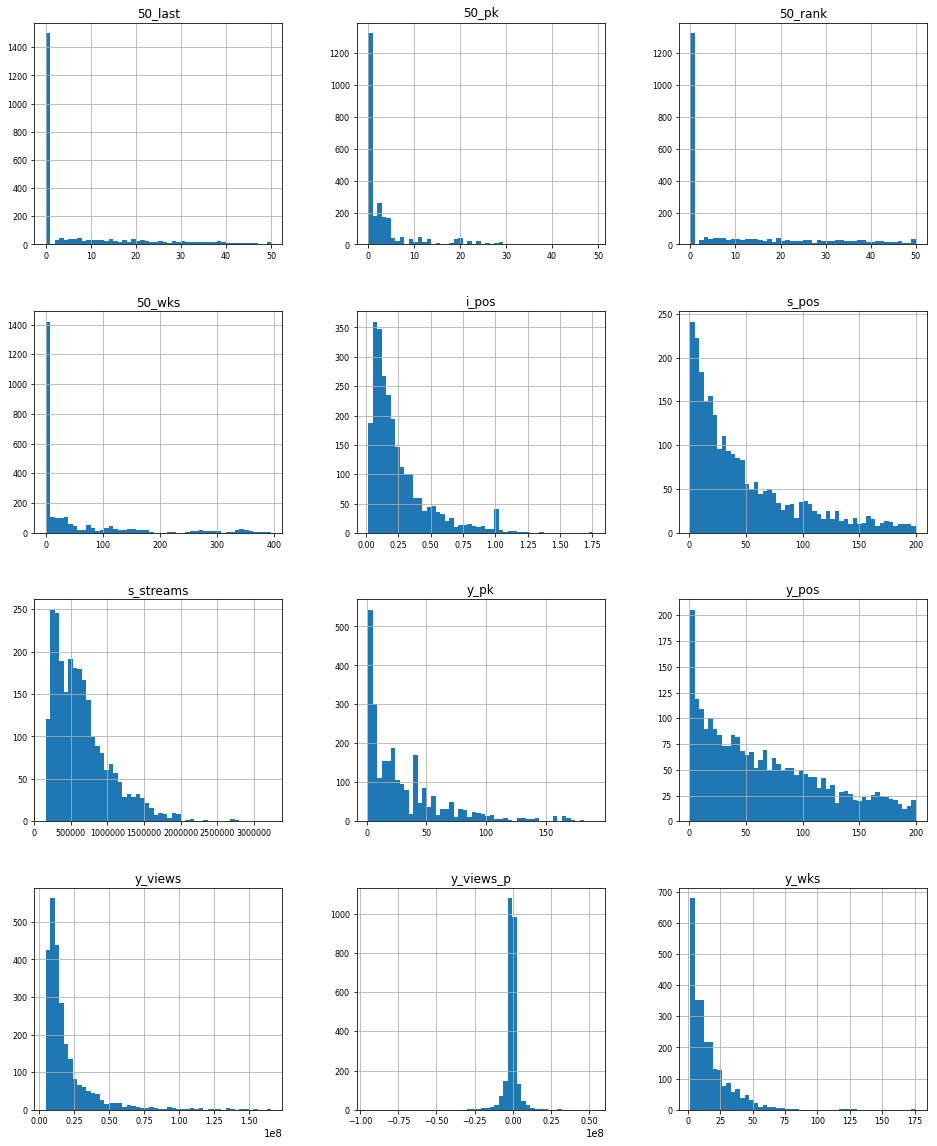

In [14]:
merged_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Above is the visualization of all our data. For all Social 50 data, we can see there are a lot of values with 0. These are songs that did not have a ranking in Social 50 and these could be counted as outliers. Besides that, we can look at the general trends of the histograms. We can see that most Social 50 data is constant while the other data follow an exponential trend.

## First Glance

In [15]:
artist_list = merged_df['artist'].unique()
artist_list.sort()
num_artists = len(artist_list)
print("Artists on chart: ", num_artists)

song_list = merged_df['title'].unique()
num_songs = len(song_list)
print("Songs on chart: ", num_songs)

date_list = merged_df['date'].unique()
num_dates = len(date_list)
print("Number of days plotted: ", num_dates)

Artists on chart:  107
Songs on chart:  217
Number of days plotted:  104


With 106 artists and 213 songs, we have close to a 1:2 ratio. We wanted to see if the top-charting artists averaged 2 popular videos, or if a majority of artists had only 1 hit song compared to other artists who had released many charting songs.

### Number of Top Ranked Songs per Artist

In [16]:
# Dict {key: artist, value: list of song names}
artist_song_dict = {}

# List of total number of songs per artist
songs_per_artist = []

# Calculate average number of top ranked songs per artist
avg_songs_per_artist = 0

for artist in artist_list:
    artist_songs = merged_df[merged_df['artist']==artist]['title'].unique()
    artist_song_dict[artist] = artist_songs
    avg_songs_per_artist += len(artist_songs)
    songs_per_artist.append(len(artist_songs))
    
avg_songs_per_artist = avg_songs_per_artist / num_artists

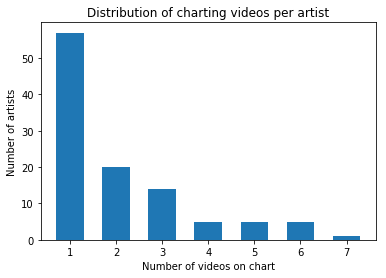

In [17]:
common_num_vids = Counter(songs_per_artist).most_common()

plt.bar([x[0] for x in common_num_vids], [x[1] for x in common_num_vids], width=0.6)
plt.xlabel('Number of videos on chart')
plt.ylabel('Number of artists')
plt.title("Distribution of charting videos per artist")
plt.show()

From this graph, we can see that over half of the artists on the chart only have 1 charting music video between 2017-2018. Less than 25% of artists have over 4 charting videos, so we should see if the number of charting videos has a correlation with view count (per artist). First, we will visualize our data on youtube views.

## `y_views`

### Distribution for Youtube Views

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


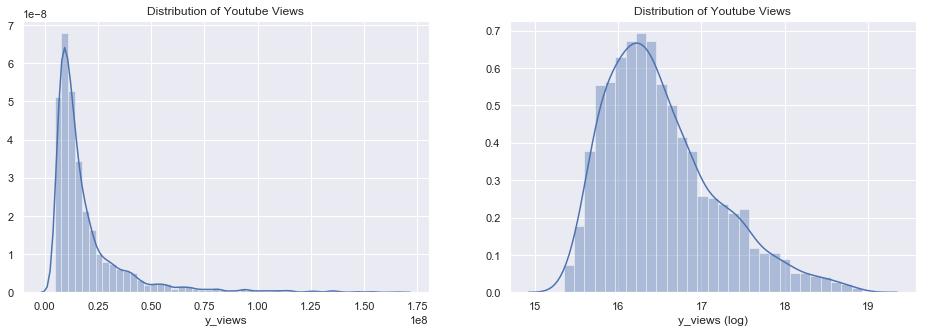

Describe y_views:
count    2.576000e+03
mean     1.963861e+07
std      1.914153e+07
min      4.631111e+06
25%      9.074922e+06
50%      1.310698e+07
75%      2.166418e+07
max      1.654796e+08
Name: y_views, dtype: float64


In [18]:
plt.figure(figsize=(16, 5))

sns.set(color_codes=True)
plt.subplot(121)
sns.distplot(merged_df['y_views']);
plt.title("Distribution of Youtube Views")
plt.xlabel("y_views")

plt.subplot(122)
sns.distplot(np.log(merged_df['y_views']));
plt.title("Distribution of Youtube Views")
plt.xlabel("y_views (log)")
plt.show()

print("Describe y_views:")
print(merged_df['y_views'].describe())

This distribution graph shows that the density of the distribution is highest around .20 from the first plot, which is roughly about 20 million views per video each day. We log transformed the y_views values in the second plot in order to visualize the distribution better. The mean value for views/day is 19.6 million and the max is 165 million, meaning that most artists have an average view count that is only a fraction of the highest charting videos. The notable left skew in our distribution means that there are a small handful of music videos that gained a lot of popularity compared to other charting music videos, and it is worth exploring to see whether or not those videos at the tail end of the distribution show a correlation to other signs of artist popularity

In [19]:
# View counts per artist for the days they're on the chart
view_count = {}

# view_count[artist][0] total
# view_count[artist][1] avg

for artist in artist_list:
    rows = merged_df[merged_df['artist']==artist]
    total = rows['y_views'].sum()
    avg = total/len(rows) #truncated
    view_count[artist] = (total,avg)

### Visualize Timeline

In [20]:
# Dict of dicts {key: song, value: dict{key: date, value: views} }
songs_per_date = defaultdict(dict)

for date in date_list:
    temp_df = merged_df.drop_duplicates(subset=["date","title","y_views"],keep="first")
    songs = temp_df[temp_df['date']==date]["title"].unique()
    for s in songs:
        views = temp_df[ (temp_df['date']==str(date)) & (temp_df['title']==str(s))]["y_views"].item()
        songs_per_date[s][date] = views

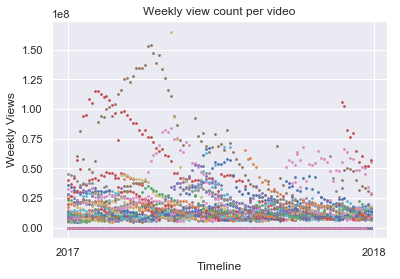

In [21]:
# All weekly view counts plotted on one graph
for song, date_dict in list(songs_per_date.items()):
    views = [ (date_dict[d] if d in date_dict.keys() else 0) for d in date_list]
    plt.scatter(date_list,views,s=3)

plt.xticks([0,104],[2017,2018])
plt.xlabel("Timeline")
plt.ylabel("Weekly Views")
plt.title("Weekly view count per video")
plt.show()

From a general overview of the timeline, it's clear that most music videos follow a rather normal or left skewed shape in terms of youtube views per week. This means that from the week which a music video enters the chart to the week which it falls out of the chart, there will almost always be a small peak in weekly views within the first half of it's life on the chart, followed by a gradual fall/plateau until it no longer is charting. From the chart, we can also see that songs are often charting for months at a time, and don't just become irrelevant within a week or two. This means that the artists that are charting are likely producing music videos that are either widely appreciated by the public or that they have a large, stable fanbase, both of which are good indicators of publicity.

### Top 10: Youtube Views

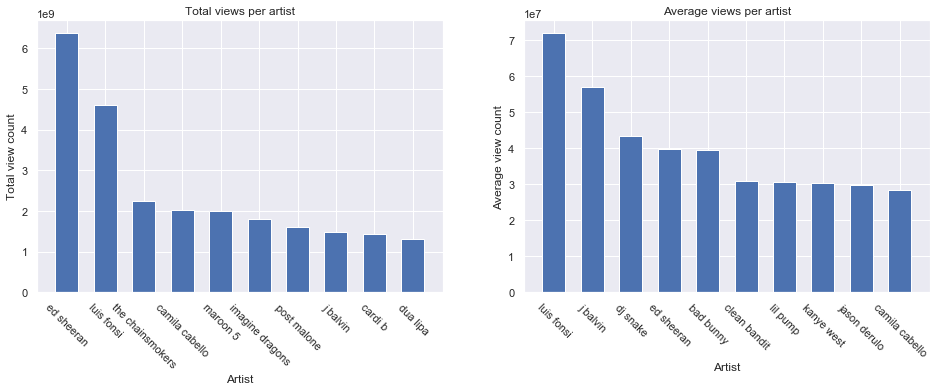

In [22]:
plt.figure(figsize=(16, 5))

# CUMULATIVE 
common_view_count_total = Counter({key: value[0] for (key, value) in 
                                   view_count.items()}).most_common()

plt.subplot(121)
plt.bar([x[0] for x in common_view_count_total][:10], 
        [x[1] for x in common_view_count_total][:10], width=0.6)
plt.xlabel('Artist')
plt.xticks(rotation=-45)
plt.ylabel('Total view count')
plt.title("Total views per artist")

# AVERAGE
common_view_count_avg = Counter({key: value[1] for (key, value) in 
                                 view_count.items()}).most_common()

plt.subplot(122)
plt.bar([x[0] for x in common_view_count_avg][:10], 
        [x[1] for x in common_view_count_avg][:10], width=0.6)
plt.xlabel('Artist')
plt.xticks(rotation=-45)
plt.ylabel('Average view count')
plt.title("Average views per artist")
plt.show()

### Correlation between total and average view counts

Correlation:  0.6723651272146602


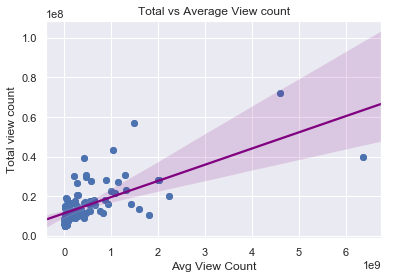

In [23]:
# setting up scatter plot
x = [value[0] for (key, value) in view_count.items()] # Avg
y = [value[1] for (key, value) in view_count.items()] # Total
plt.xlabel("Avg View Count")
plt.ylabel("Total view count")
plt.title("Total vs Average View count")

# plotting scatter plot
plt.scatter(x,y)
sns.regplot(x, y, line_kws = {'color':'purple'})
sp_yt = plt.gcf()

# Calculating correlation between Average View Count and Total View Count
avg_total_view_corr = np.corrcoef(x,y)[0,1]

print("Correlation: ", avg_total_view_corr)

We plotted the correlation between an artist's total view counts and their average view count (per video per week), in order to see if artists with more cumulative views (as a result of either longevity on the charts, having multiple hit songs, or just having extremely high view counts for the view days it is charting) have music videos that garner more weekly views than other artists' music videos. Looking at the data, We can see that there is a relatively strong positive correlation. However, inspecting the plot visually, most of the data points are clustered towards lower total view counts and lower average view counts, with only a handful of points that are outliers which may have skewed the graph. This hints that most artists only have one hit song (as shown in above visualizations), and that artists with more cumulative views often are more "popular" by attracting higher average views.

### Correlation between number of videos and average views per video

Correlation:  0.20013173663070077


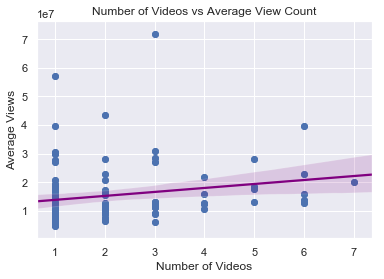

In [24]:
numVideos_vs_avgViews = []

# setting up scatter plot
for artist in artist_list:
    numVideos = len(artist_song_dict[artist])
    avgViews = view_count[artist][1]
    numVideos_vs_avgViews.append((numVideos,avgViews))
    
x = [tup[0] for tup in numVideos_vs_avgViews] # number of videos
y = [tup[1] for tup in numVideos_vs_avgViews] # average views per video
plt.xlabel("Number of Videos")
plt.ylabel("Average Views")
plt.title("Number of Videos vs Average View Count")

# plotting scatter plot
plt.scatter(x,y)
sns.regplot(x, y, line_kws = {'color':'purple'})
sp_yt = plt.gcf()

# Calculating correlation between number of videos and average views per artist
numVideos_avgViews_corr = np.corrcoef(x,y)[0,1]

print("Correlation: ", numVideos_avgViews_corr)

From above, we had mentioned that we wanted to see if the number of charting videos an artist has is correlated with with the average view count per video for that artist. It is possible that an artist may have more views on average when they have more hit songs, because they are more popular to the public. It is also possible that an artist may be a "one-hit-wonder" and have really high view average despite it being the only song they have that got into the top charts. After graphing it, we can see that there is a moderately positive correlation of .20 between number of videos on the chart and average view count per video. We can't strongly conclude that artists have more views when they have more hit songs.

## `i_pos` vs `s_pos`

   To check for any correlation between where artists are ranked on YouTube, in comparison to Spotify, we plotted the data on a bar graph to showcase the discrepancies clearly. Due to the high volume of artists, we opted to showcase different subsets of the data, to maintain consistency, as well as obtain clear and decluttered visualizations. 
   This first bar graph shows the first 99 artist's YouTube position, y_pos, in orange, next to their Spotify position, s_pos, in blue. The y-axis has been inverted because 1 is the highest possible ranking, while 200 is the lowest. This means that the lower the bar graph reaches, the lower the corresponding artist ranks. 
   Observing the plot, there are visible discrepancies between the rankings. Spotify and YouTube rankings do not agree on majority of the artists, with YouTube rankings being significantly lower by at least 25 spots, the majority of the time.  

(-0.5, 99.5)

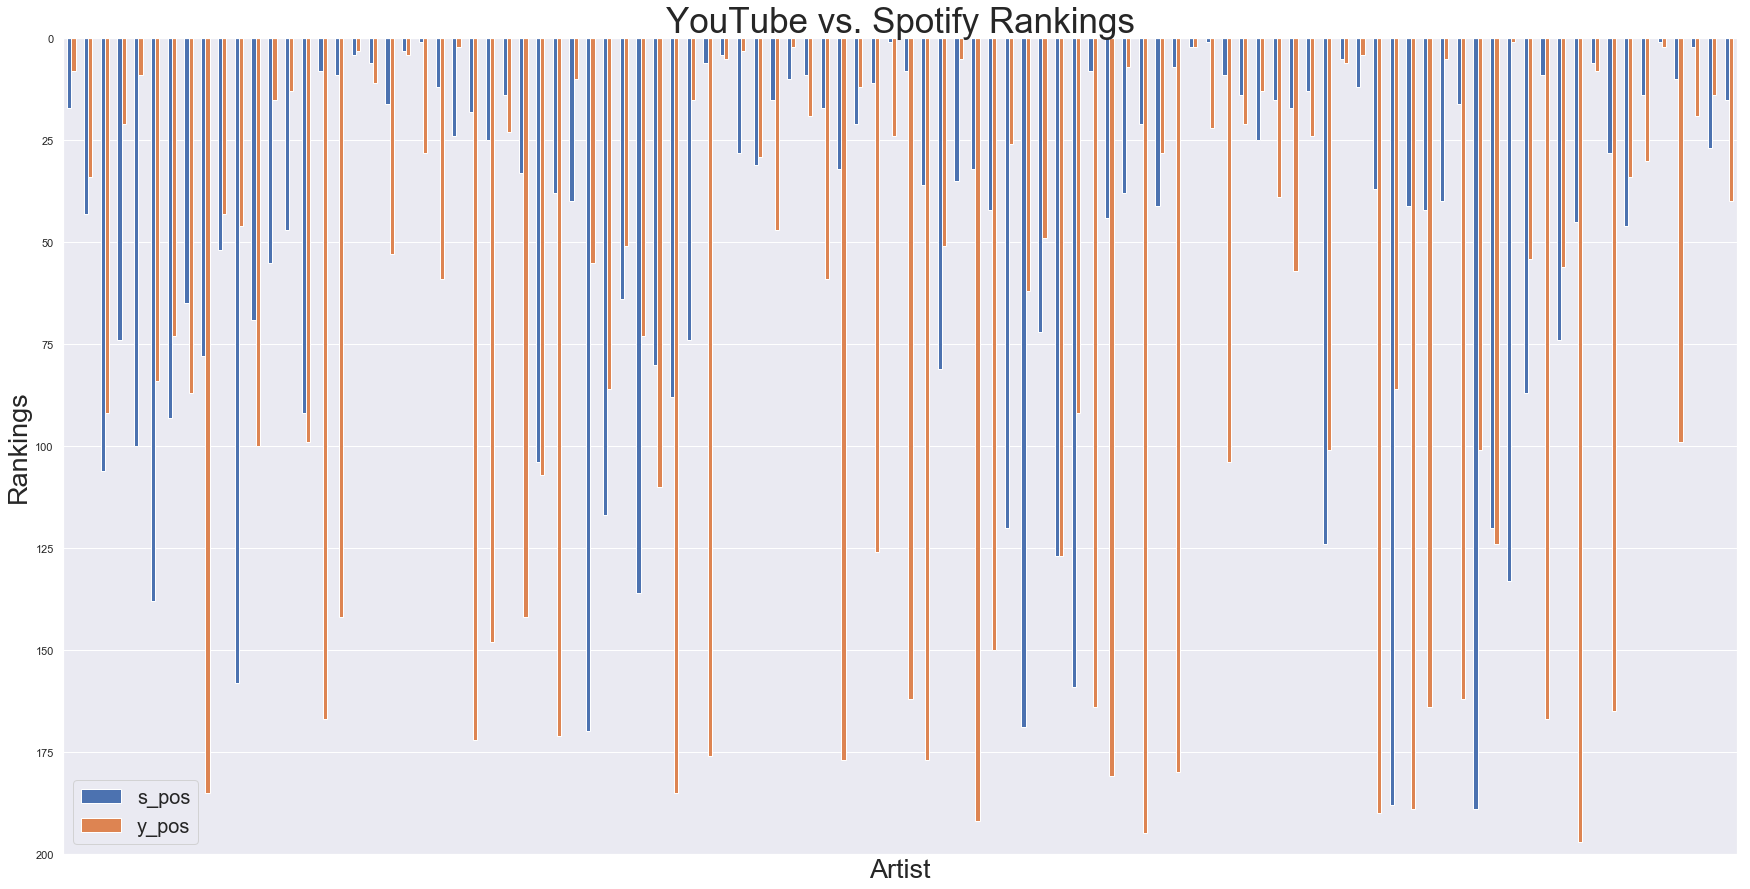

In [25]:
#Creating bar graph to show Spotify versus YouTube rankings by artist
#Using a subset of the artists to show differences in rankings clearly 
merged_df.iloc[0:100].plot(x="artist", y=["s_pos", "y_pos"], kind="bar", 
                           figsize= (30,15))

plt.xlabel('Artist', fontsize = 27)
plt.ylabel('Rankings', fontsize = 27)

plt.title('YouTube vs. Spotify Rankings', fontsize = 35)
plt.xticks([])
plt.legend(fontsize = 20)

#Inverting Y Axis because 1 is the highest ranking, with 200 being the lowest
plt.ylim(200, 0)

#Removing the artist tick marks to declutter
plt.xlim()

This plot uses a bigger subset, 575 artists, to showcase the discrepancies. Although a lot busier, it is still possible to see that there are clear differences in the ranking between the sites. However, both categories appear to be more similar in the amount of times they vary signigicantly, by more than 25 spots. This shows there is no correlation between the artist rankings in YouTube vs Spotify lists.

(-0.5, 575.5)

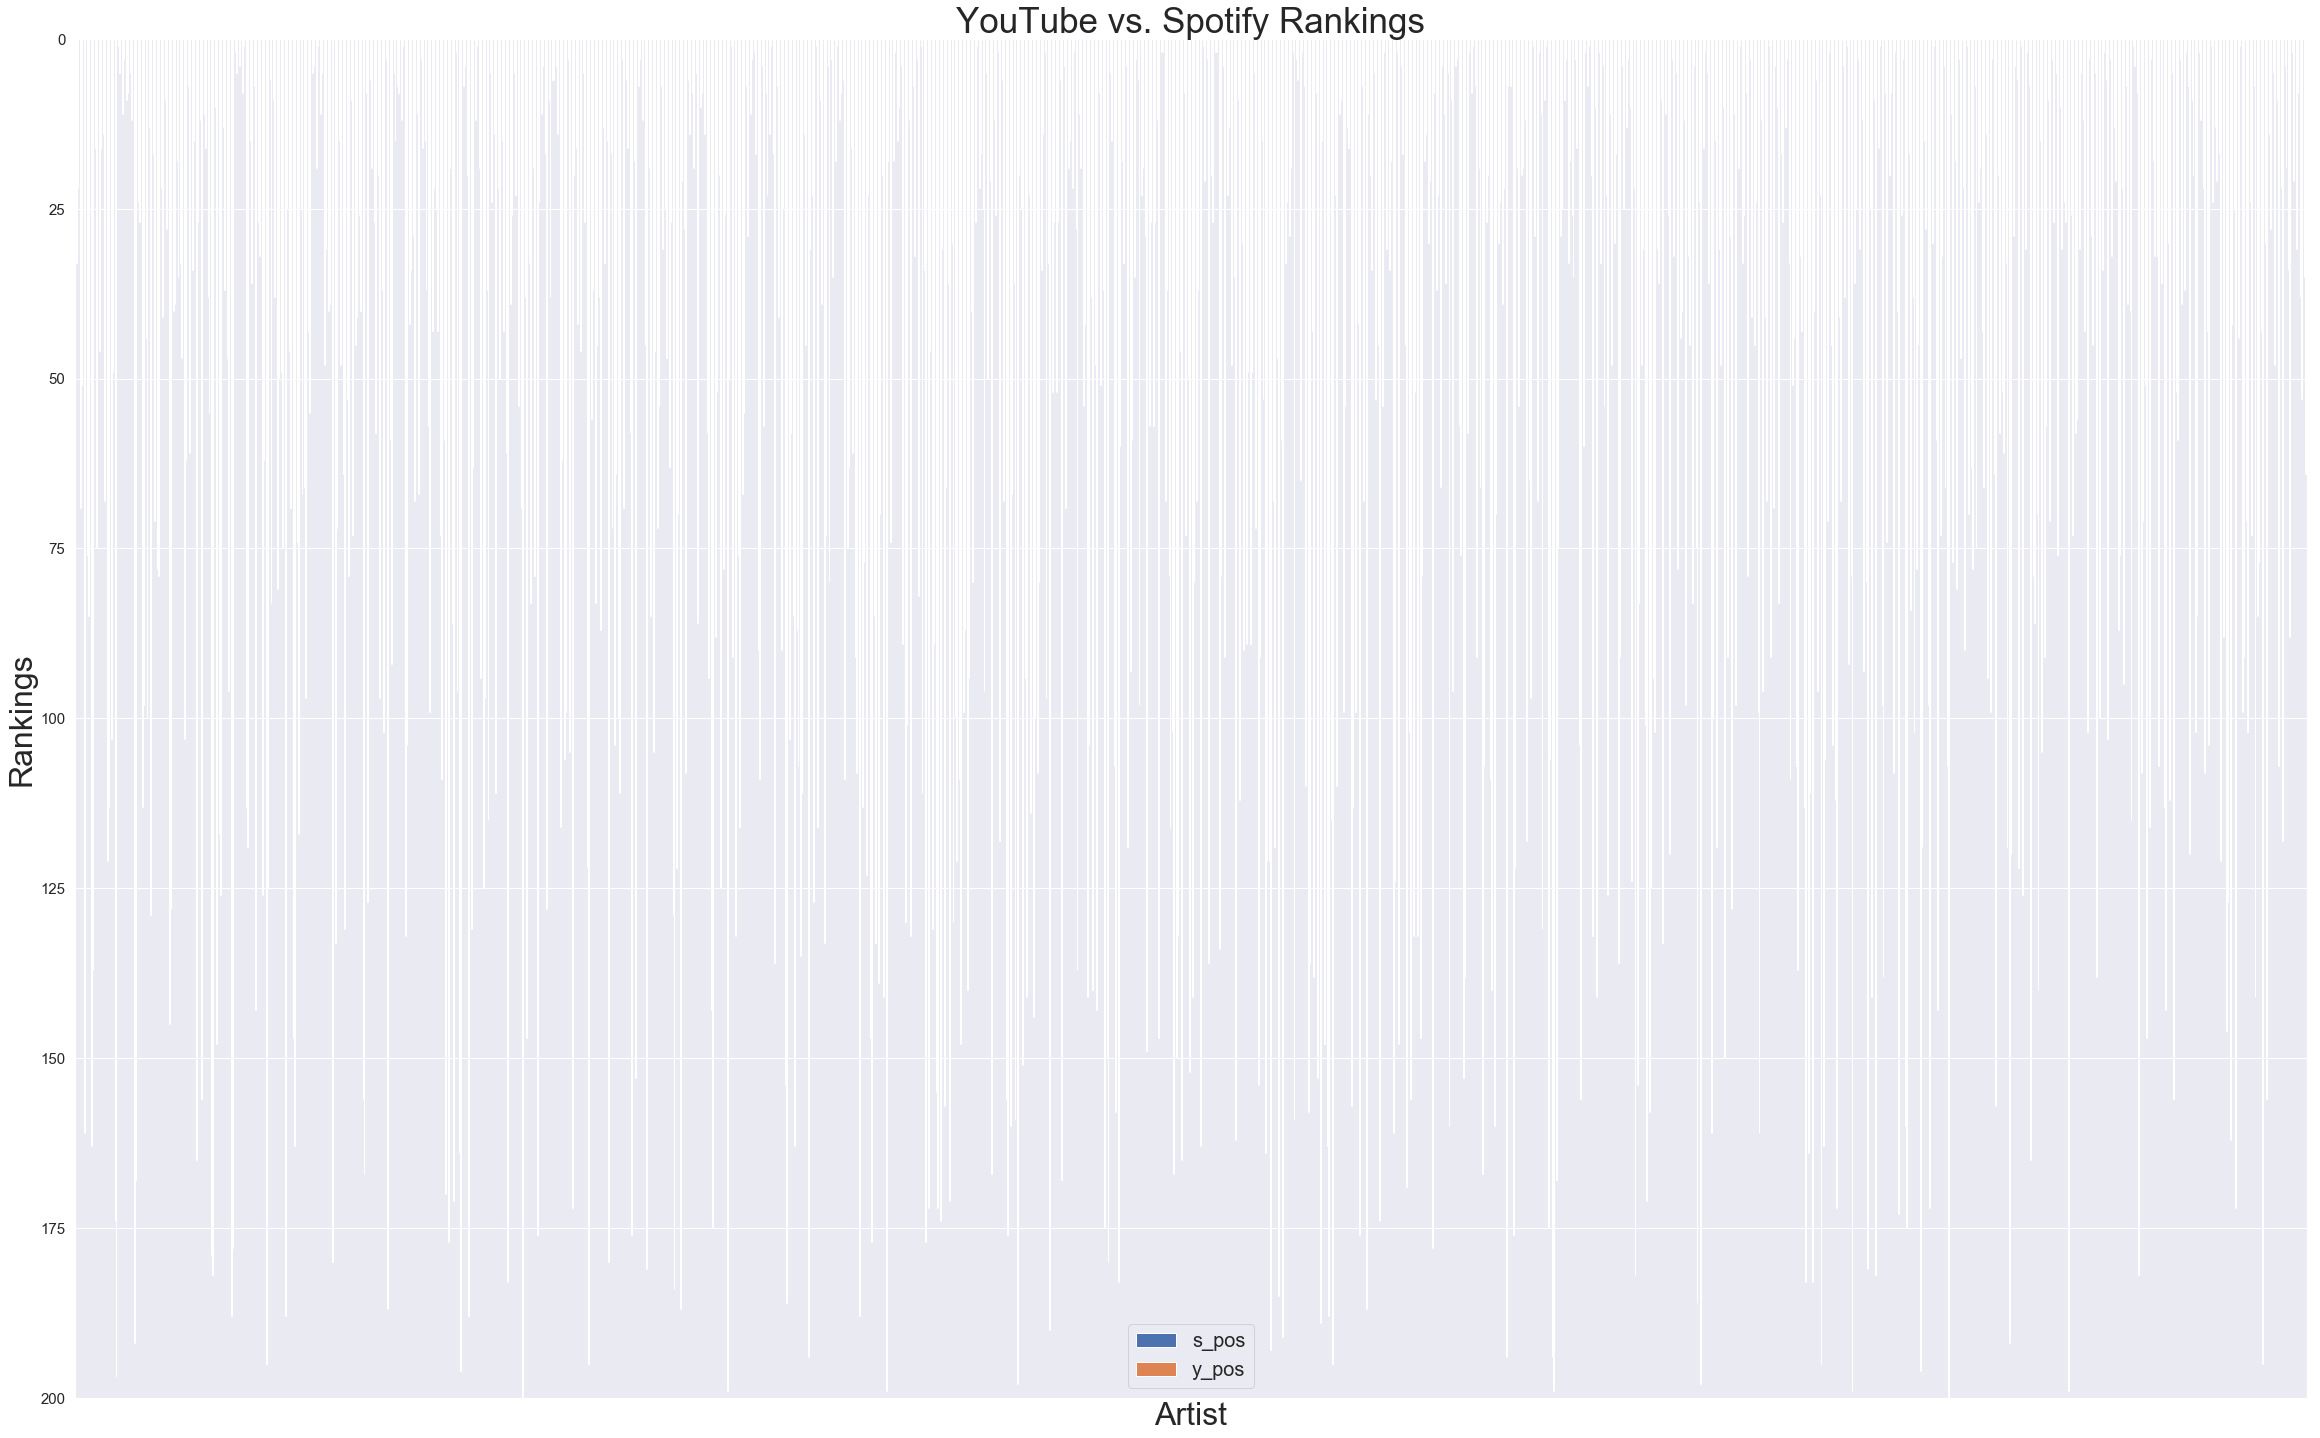

In [26]:
# Using a bigger subset to show consistency in the ranking differences
merged_df.iloc[2000:].plot(x="artist", y=["s_pos", "y_pos"], kind="bar", 
                           figsize= (40,25))

plt.xlabel('Artist', fontsize = 32)
plt.ylabel('Rankings', fontsize = 32)

plt.title('YouTube vs. Spotify Rankings', fontsize = 35)
plt.xticks([])
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)

#Inverting Y Axis because 1 is the highest ranking, with 200 being the lowest
plt.ylim(200, 0)

#Removing artist tick marks for decluttering
plt.xlim()

## `s_pos` vs `y_wks`
For chart reading, in "Position on Spotify Charts" a value of 200 is the lowest and a value of 1 the highest chart positon a song can have. 

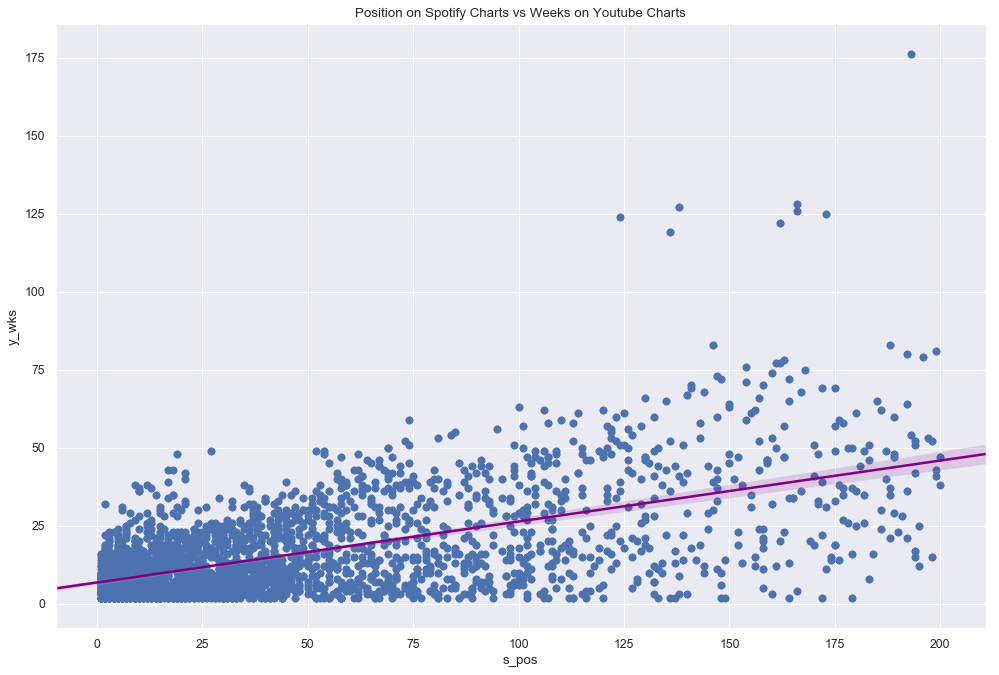

In [27]:
#setting up scatter plot
x = merged_df['s_pos']
y = merged_df['y_wks']

plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("Position on Spotify Charts")
plt.ylabel("Weeks on Youtube Charts")
plt.title("Position on Spotify Charts vs Weeks on Youtube Charts")

#plotting scatter plot
data = merged_df
plt.scatter(x,y)
sns.regplot('s_pos', 'y_wks', data = data, line_kws = {'color':'purple'})
sp_yt = plt.gcf()

#Calculating correlation between Positon and weeks
sp_yt_cor = np.corrcoef(x,y)[0,1]

In [28]:
print("CORRELATION: ", sp_yt_cor)

CORRELATION:  0.5840006132303618


From the scatter plot we can see that the there seems to be a small relationship between the Weeks on Youtube charts and Position on Spotify charts for a song. The correlation between the weeks a song is on Youtube charts and its position in Spotify Charts are positive with a value of .5840006132303617. This means that the longer a song is on Youtube charts, the lower the songs position will be on Spotify Charts. We can assume that a song's highest position on Spotify Charts will be when that song has been recently released and has spent the least amount of weeks on Youtube Charts. Since the correlation is not higher and more linear, however, we can not say that a small value for weeks on Youtube charts will definitively result in a high position on Spotify charts.

When looking at the graph we can see that a value of 50 for Weeks on Youtube Charts, Spotify Chart Positon of a song will not be within top 10, but can be within the top 20. This further proves that a song's highest position for Spotify Charts will most likely be when the song has spent less time on Youtube charts.

In [29]:
#Correlation of all other columns to 'y_wks'
df_corr = merged_df.corr()['y_wks']
print(df_corr)

i_pos       -0.216454
s_pos        0.584001
s_streams   -0.432680
y_pos        0.031030
y_views     -0.029296
y_views_p    0.008288
y_wks        1.000000
y_pk        -0.260432
50_rank      0.030638
50_pk        0.009479
50_last      0.027773
50_wks      -0.039006
Name: y_wks, dtype: float64


Above is the correlation of 'y_wks' and the other variables. When looking through the correlation we can see there is some noticeable valued correlation between 'y_wks' and 's_pos' and 's_streams'. The correlation between 'y_wks' and 's_pos' is positive. While the correlation between 'y_wks' and 's_streams' is negative. For everything else the correlation is to miniscule to be notable or significant.

## `y_views_p` vs `50_rank`,` 50_last`
Along with the release of a music video, an artist has to publize it on social media and interact with their fans. Since *Billboard* Social 50 meaures how many additional followers and fans as well as the website views the artist gains. 

Here is the questions we want to ask from the columns:

**Do artists rise on the Social 50 when YouTube music video views have large percentage increase?**

We hypothesize that artists climb higher in Social 50 ranking when they has more percentage view increase on YouTube. We want to test this hypothesis using the the columns `y_views_p`, `50_rank`, `50_last`.

Because we do not want to change `merged_df`, we drop the irrelavent columns and store it in a new dataframe `df_y5`.

In [30]:
df_y5 = merged_df[['artist','date', 'title', 'y_views', 
                   'y_views_p', '50_rank', '50_last']]

Before we proceed with the analysis, we need to transform our data to represent the percentage increase in music video views and the ranking increase.

In order to determine how much a music video increases views compared to last week. We compute the percentage of increase by `y_views_p` / (`y_views` - `y_views_p`) and store it in a column `y_views_inc`.

In [31]:
df_y5 = df_y5.assign(y_views_inc = df_y5['y_views_p'] / 
                     (df_y5['y_views'] - df_y5['y_views_p']))

First we drop the rows that have 0 entry in `50_rank` because they don't represent accurate rank progress.

Then we replace the 0 entries in `50_last` with 51, indicating a lower ranking (out of the chart).

In order to determine if an artist rises on the Social 50 chart, we need to calculate the difference between `50_rank` and `50_last`. We then negate the difference to show the "progress" an artist has on the chart. We store this value in the column `prog_50`.

In [32]:
df_y5.drop(df_y5[df_y5['50_rank'] == 0].index, inplace=True)
df_y5['50_rank'].replace(0, 51, inplace=True)
df_y5['50_last'].replace(0, 51, inplace=True)

df_y5 = df_y5.assign(prog_50 = -(df_y5['50_rank'] - df_y5['50_last']))
df_y5.head()

,artist,date,title,y_views,y_views_p,50_rank,50_last,y_views_inc,prog_50
0,bruno mars,2017-01-05,24k magic,28393541,676486,41.0,25.0,0.024407,-16.0
3,fifth harmony,2017-01-05,work from home,19774096,791424,12.0,22.0,0.041692,10.0
5,chris brown,2017-01-05,party,8678474,-1373674,14.0,21.0,-0.136655,7.0
9,the chainsmokers,2017-01-05,don't let me down,12975286,-404504,25.0,31.0,-0.030232,6.0
11,twenty one pilots,2017-01-05,ride,7839872,-65054,33.0,51.0,-0.008230,18.0


### Distribution of `y_views_inc` and `prog_50`
First we want to see the distribution of the two columns.

y_views_inc median = -0.037409644393228386
prog_50 median = 1.0


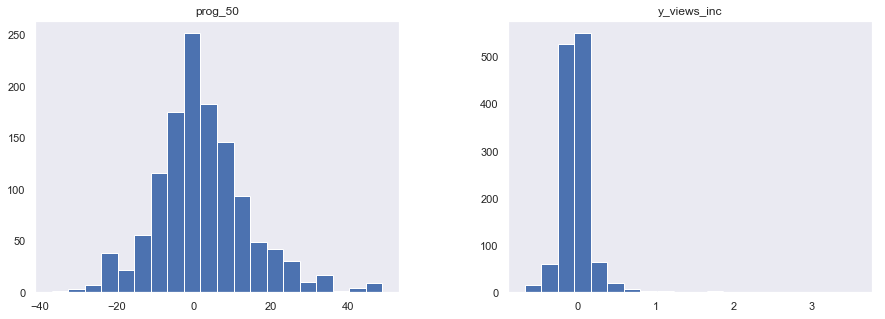

In [33]:
print('y_views_inc median =', df_y5['y_views_inc'].median())
print('prog_50 median =', df_y5['prog_50'].median())

hist = df_y5.hist(['y_views_inc', 'prog_50'], bins=20, figsize=(15,5), grid=False)

From the histograms above, we can see that `y_views_inc` has a normal-like distribution. Most of the YouTube view counts have slight decrease compared to last week (the median is also negative). This makes sense because views tend to be higher when a video is first release. Less and less people are going to watach it during the following week. As is shown the grapg, we have less videos that increase above 20%.

`prog_50` looks like a normal distribution centered at 0-1. This makes sense because lots of the chart entry tend to climb slowly. Only few artist can have sudden increase in position in Social 50. 

We can test the normality of `y_views_inc` and `prog_50` by using hypothesis testing:
- Null hypothesis: `y_views_inc`/`prog_50` is not normally distributed 
- Alternative hypothesis: `y_views_inc`/`prog_50` is normally distributed 

In [34]:
from scipy.stats import normaltest
p_value1 = normaltest(df_y5['y_views_inc'])[1]
p_value2 = normaltest(df_y5['prog_50'])[1]

p_value1, p_value2

(0.0, 7.956835702487483e-26)

Using an alpha significance value of 0.01, we can see that both `p_value1` and `p_value2` are much less than the significance value. Therefore, we reject the null hypothesis that `y_views_inc`/`prog_50` is not normally distributed.

### The relationship between `y_views_inc` and `prog_50`
Next we use a scatter plot to observe the relationship between `y_views_inc` and `prog_50`.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


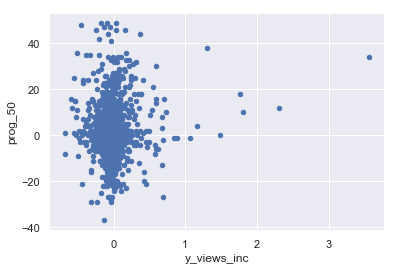

In [35]:
scatter = df_y5.plot.scatter("y_views_inc", "prog_50")

From this scatterplot, we can see that the data points seems random and there is no appearent correlation between `y_views_inc` and `prog_50`. We want to confirm this by calculating the correlation between the two columns.

In [36]:
corr = df_y5['y_views_inc'].corr(df_y5['prog_50'])
print("corr =", corr)

corr = 0.0720708397410731


From the correlation value, we can see that there is little coreleation between `y_views_inc` and `prog_50`. 

To be sure of this, we want to use a linear model to fit these data and see if YouTube views percentage increase can predict Social 50 ranking increase.

In [37]:
import patsy
import statsmodels.api as sm

outcome, predictors = patsy.dmatrices('prog_50 ~ y_views_inc', df_y5)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                prog_50   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.532
Date:                Wed, 12 Jun 2019   Prob (F-statistic):             0.0107
Time:                        14:11:13   Log-Likelihood:                -4898.8
No. Observations:                1253   AIC:                             9802.
Df Residuals:                    1251   BIC:                             9812.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2840      0.343      6.662      

From the value `R-squared`=0.005, we can see it is a low number suggetsing a poor model fit. Therefore, this linear model does not accurately summarize the relationship between `y_views_inc` and `prog_50`.

# Ethics & Privacy

Ethicality was central to us as we proceeded with our project. We advanced with our analysis while adopting ethical practices centered on removing bias and maintaining privacy. We did not intend to cause harm or sacrifice morality for results; but instead, strived for security and fair analysis as we searched for the correlations between our datasets. Our research did not result in any personal gain or advancement.

To approach our research question ethically, we considered the privacy invasion that data collection included. All of the data was free accessible data, and the Kworb.net creator specifically noted that all data provided by his website was free to use. The other data was accessible through Python API packages and the liscense of these packages also specifically note permissions granted free of use to use their programs. Once scraping and gathering the data there were some privacy concerns, such as specific links to the songs, which were dropped from the final dataset. We chose to keep artist's names and song names, as this data was essential for our analysis, but to combat ethical concerns and discriminating biases, we did not set an emphasis on the specifics of artist's names. Instead, we only accounted for the logistics of the artist’s popularity provided by our dataset and not the specific artist demographics.

Although our datasets only composes of musicians, our research question was specifically geared towards answering a correlation between musician's popularity and their Youtube popularity so there is no potential bias here. Since our data consists of data from charts, every population of artist is likely to be included in the charts. There may be potential bias because our data only includes Spotify, Itunes, Social 50, and Youtube Charts but does not take into account other third party music charts. There are more biases since the data was from U.S. charts, so it only reflects the U.S. population. However, since we included multiple popular charts that is common in the U.S. demographic, all of these charts present a good sample of the U.S. populus to represent the popularity of a musician in the U.S.

# Conclusion & Discussion

In this digital age, artists have the capacity to extend their reach to a wide and diverse audience. We set out to explore the impacts this growing platform has on artist’s popularity. Focusing on YouTube, we hypothesized that there would be a positive correlation between an artist’s YouTube popularity, and their overall popularity.  Our concept of popularity was based off of total streams on various charts, Spotify and iTunes, as well as artist social engagement, taken from Social 50 Billboard rankings. Using this data, we set out to determine the correlation and relationships between the artist’s overall activity, as corresponding to their YouTube activity by visualizing the data in various forms. This allowed us to view the data from different angles, as well as gather sufficient support and possibilities to answer our hypothesis.

When directly analyzing YouTube rankings in comparison to Spotify rankings, we found varying discrepancies from both charts. This means that there is not a direct correlation between these two as indicators of popularity, as the artists differed by over 25 spots the majority of the time. This could be explained by the comparison we analyzed between the amount of time an artist spends on the YouTube charts, in relation to their position on Spotify. We found that the artists are at a higher position on Spotify, when they have less time appearing on the YouTube charts. This conclusion lends itself to the weekly chart analysis we explored, finding that the song’s peak is at their release, with a gradual plateau after a few weeks, explaining the inverse relationship between the two. Continuing with the breakdown, we saw no apparent correlation between YouTube views increasing, as a factor of progression on the social interaction rank, Social 50. Contrary to our initial hypothesis, the two are not affected by each other.

Although we had ample data, we were limited in the dataset because we had to drop entries when merging when they did not appear in one of the charts. Since we aimed to analyze our data through the specific streaming and ranking charts, we were restricted to those appearing in them. This means that there are a number of artists and songs who are not represented in our dataset, which leads to possible bias. We were also restricted to data from 2017-2018, due to this being the only overlapping years between the charts we focused on. This lends itself to the possibility of these years as outliers, and not entirely accurately representative of the data in previous and future years.

Due to our focus on such popular and widespread streaming services, the impact of this work on society focuses on the nature of popularity in streaming services. This data showcases the variability and volatility of rankings across popular comparison sites. Due to the different factors they take into their algorithms, it is possible for artist’s to aim their projects to gain high positions on rankings by manipulating their marketing and advertizing strategies. With the rise of these platforms, there is also a rise of companies which receive money for promoting and giving them false views. Instead of focusing on their art, there is a prioritization of fame and theatrics.